In [1]:
import sys
sys.path.append('..')

In [2]:
from src.utils import load_data

In [3]:
df = load_data('../data/01_processed/BrentOilPrices_Cleaned.csv')
df.head()

,Date,Price,Log_Return
0,1987-05-20,18.63,NaN
1,1987-05-21,18.45,-0.009709
2,1987-05-22,18.55,0.005405
3,1987-05-25,18.60,0.002692
4,1987-05-26,18.63,0.001612


In [4]:
df = df.set_index('Date').sort_index()
df.head()

,Price,Log_Return
Date,,
1987-05-20,18.63,NaN
1987-05-21,18.45,-0.009709
1987-05-22,18.55,0.005405
1987-05-25,18.60,0.002692
1987-05-26,18.63,0.001612


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


--- Analyzing data for 1519 days from 2005-01-01 to 2010-12-31 ---


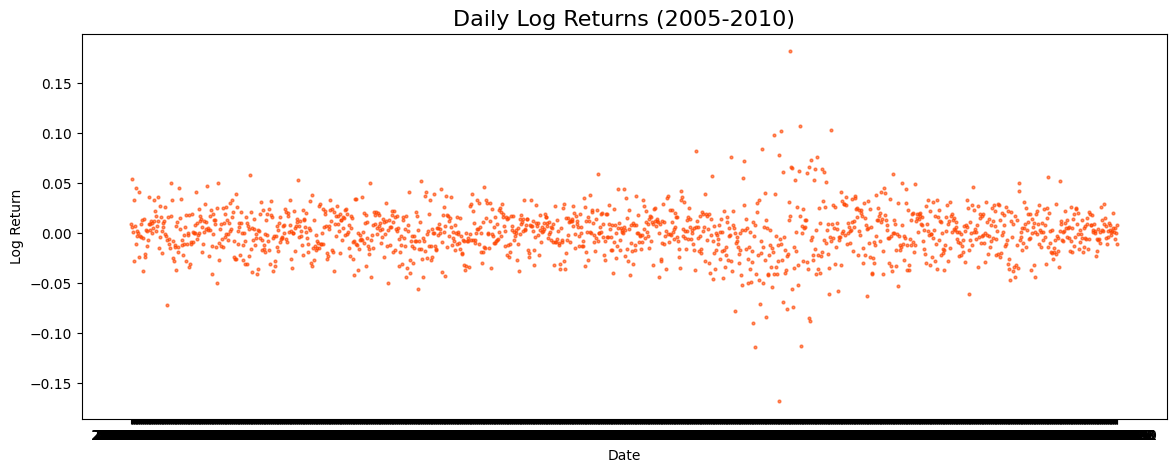

In [6]:
import pymc as pm
import arviz as az

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Isolate the Period for Analysis ---
start_date = '2005-01-01'
end_date = '2010-12-31'
df_subset = df.loc[start_date:end_date]

# Extract the log returns for modeling (and drop the initial NaN)
log_returns = df_subset['Log_Return'].dropna()
dates = log_returns.index

print(f"--- Analyzing data for {len(log_returns)} days from {start_date} to {end_date} ---")

# Plot the log returns for this specific period to see what we're modeling
plt.figure(figsize=(14, 5))
plt.plot(dates, log_returns, 'o', markersize=2, color='orangered', alpha=0.6)
plt.title('Daily Log Returns (2005-2010)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

In [ ]:
import numpy as np
# Get the number of data points for our model
n_days = len(log_returns)

# Define the Bayesian Change Point model using a PyMC context
with pm.Model() as volatility_model:
    # 1. Define the Prior for the switch point (tau)
    # This is the unknown day where the volatility changes.
    # We assume it could be any day with equal probability.
    tau = pm.DiscreteUniform("tau", lower=1, upper=n_days - 1)

    # 2. Define Priors for the "before" and "after" volatilities (sigma)
    # Volatility must be a positive value. An Exponential distribution is a good choice.
    sigma_1 = pm.Exponential("sigma_1", 1.0)
    sigma_2 = pm.Exponential("sigma_2", 1.0)

    # 3. Use a switch function to select the correct volatility
    # If the current day index is before tau, use sigma_1.
    # If it's on or after tau, use sigma_2.
    day_idx = np.arange(n_days)
    current_sigma = pm.math.switch(tau > day_idx, sigma_1, sigma_2)

    # 4. Define the Likelihood
    # This connects the model to our actual data.
    # We assume the log returns are normally distributed around a mean of 0,
    # with the volatility determined by our 'current_sigma'.
    returns = pm.Normal("returns", mu=0, sigma=current_sigma, observed=log_returns)

    # 5. Run the Sampler (MCMC)
    # This is the computational engine that finds the posterior distributions.
    trace = pm.sample(draws=2000, tune=1000, cores=1)

print("\n--- MCMC Sampling Complete ---")

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [sigma_1, sigma_2]


Output()

c:\Users\user\Documents\Datasience\birhan_energies_oil_analysis\venv\Lib\site-packages\pytensor\scalar\basic.py:195
2: RuntimeWarning: overflow encountered in cast
  return sum(inputs)

In [ ]:
# --- 1. Check for Convergence ---
# The summary table gives us key statistics. We are looking for 'r_hat' values close to 1.0.
# An r_hat of 1.0 indicates that the different simulation chains have converged to the same result.
summary = az.summary(trace, var_names=['tau', 'sigma_1', 'sigma_2'])
print("--- Model Summary ---")
print(summary)

# --- 2. Identify the Change Point ---
# Plot the posterior distribution of 'tau'. A sharp peak tells us the model is
# very certain about WHEN the change occurred.
az.plot_posterior(trace, var_names=['tau'], hdi_prob=0.95)
plt.suptitle('Posterior Distribution of Change Point (tau)', y=1.02)
plt.show()

# --- 3. Quantify the Impact ---
# Plot the posterior distributions for the "before" and "after" volatilities.
# This allows us to see how much the volatility changed.
az.plot_posterior(trace, var_names=['sigma_1', 'sigma_2'], hdi_prob=0.95)
plt.suptitle('Posterior Distributions of Volatility Parameters', y=1.02)
plt.show()

# --- 4. Calculate Probabilistic Impact ---
# We can calculate the probability that volatility was higher after the change point.
posterior_samples = trace.posterior
prob_increase = (posterior_samples['sigma_2'] > posterior_samples['sigma_1']).mean().item()
print(f"\nProbability that volatility increased after the change point: {prob_increase:.2%}")